$\textbf{Note: all those exercises should be done using python with pyccel openmp}$

## $\textbf{Exercise 1 Hello World}$

1. Write an OpenMP program displaying the number of threads used for the execution and the rank of each of the threads.
3. Test the programs obtained with different numbers of threads for the parallel program.

**Output Example**
```shell
>> Python hello.py
Hello from the rank 2 thread
Hello from the rank 0 thread
Hello from the rank 3 thread
Hello from the rank 1 thread
Hello from the rank 4 thread
Parallel execution of hello_world with 4 threads
```
*Note that the output order maybe different*

In [1]:
%%file hello.py
if __name__ =="__main__":
    from pyccel.stdlib.internal.openmp import(
        omp_get_num_threads, omp_get_thread_num,
        omp_in_parallel, omp_set_num_threads
    )
    #$omp parallel
    
    rank = omp_get_thread_num(), omp_get_num_threads()
    print("Hello from the rank ",rank[0] , "thread")
    
    #$omp end parallel
    
    print("Parallel execution of hello_world with",rank[1] ,"threads")


Overwriting hello.py


In [2]:
!pyccel --language=c hello.py --openmp

In [3]:
! ./hello

Hello from the rank  2 thread
Hello from the rank  5 thread
Hello from the rank  3 thread
Hello from the rank  7 thread
Hello from the rank  4 thread
Hello from the rank  6 thread
Hello from the rank  1 thread
Hello from the rank  0 thread
Parallel execution of hello_world with 8 threads


In [4]:
import os
import time
import pyccel
import numpy as np

In [5]:
os.environ['OMP_NUM_THREADS'] = "4"
! ./hello

Hello from the rank  0 thread
Hello from the rank  3 thread
Hello from the rank  1 thread
Hello from the rank  2 thread
Parallel execution of hello_world with 4 threads


In [6]:
os.environ['OMP_NUM_THREADS'] = "5"
! ./hello

Hello from the rank  0 thread
Hello from the rank  3 thread
Hello from the rank  1 thread
Hello from the rank  4 thread
Hello from the rank  2 thread
Parallel execution of hello_world with 5 threads


In [7]:
os.environ['OMP_NUM_THREADS'] = "8"
! ./hello

Hello from the rank  0 thread
Hello from the rank  2 thread
Hello from the rank  6 thread
Hello from the rank  7 thread
Hello from the rank  4 thread
Hello from the rank  5 thread
Hello from the rank  3 thread
Hello from the rank  1 thread
Parallel execution of hello_world with 8 threads


## $\textbf{Exercise 2 Matrix product}$

Considering the following code for matrix product:

1. Using pyccel, epyccelize the `matrix_prod` function, and time the execution of epyccelized function.
2. Insert the appropriate OpenMP directives and analyse the code performance.
3. Test the loop iteration repartition modes (`STATIC`, `DYNAMIC`, `GUIDED`) and vary the chunk sizes.
**Example output**

```bash
   Value of M and N           : 20 20 
    Temps elapsed              : 0.0009012222290039062 
    Temps CPU                  : 0.0 
    Partiel results            : 2790.0 2690.0 ... -3610.0 -4350.0 

 Execution of Matrix production in parallele with                     8 threads
```

In [8]:
def matrix_prod(A, B, C, N, M):
    
    for i in range( M ):
        for j in range( N ):
            A[ i, j ] = (i + 1) + (j + 1)
    
    for i in range( N ):
        for j in range( M ):
            B[ i, j ] = (i + 1) - (j + 1)
    
    for i in range( M ):
        for j in range( M ):
            C[ i, j ] = float(0)

    # Matrix Production
    for i in range( M ):
        for j in range( M ):
            for k in range( N ):
                C[ i, j ] += A[ i, k ] * B[ k, j ]
    
    return C


if __name__ == "__main__":
    import numpy as np
    import time
    import math

    M = 20
    N = 20

    # Declare Matrices
    A = np.empty((M, N), dtype=np.double)
    B = np.empty((N, M), dtype=np.double)
    C = np.empty((M, M), dtype=np.double)
    
    #run and time the matrix_prod function
    
    elapsed_start = time.time()
    cpu_start = time.process_time()
    
    res_mat = matrix_prod(A, B, C, N, M)
    
    
    elapsed = time.time() - elapsed_start
    cpu_time = time.process_time() - cpu_start

    print("Value of M and N  :",N, M)
    print("Temps elapsed   :", elapsed)
    print("Temps CPU :", cpu_time)
    print("Partiel results :", res_mat[:7, 1])

Value of M and N  : 20 20
Temps elapsed   : 0.005752086639404297
Temps CPU : 0.006071681999999967
Partiel results : [2620. 2790. 2960. 3130. 3300. 3470. 3640.]


### $\textbf{matrix_prod function pyccelization}$

In [9]:
def matrix_prod_pyccel(A:'int[:,:]', B:'int[:,:]', C:'float[:,:]', N:'int', M:'int'):
    
    for i in range(M):
        for j in range(N):
            A[i, j] = (i+1) + (j+1)
    
    for i in range(N):
        for j in range(M):
            B[i, j] = (i+1) - (j+1)
    
    for i in range(N):
        for j in range(M):
            C[i, j] = float(0)
    
    # Matrix Production
    for i in range(M):
        for j in range(M):
            for k in range(N):
                C[i, j] = C[i, j] + A[i, k]*B[k, j]
                

In [10]:
N, M = 5, 5
A = np.empty((M, N), dtype=np.double)
B = np.empty((N, M), dtype=np.double)
C = np.empty((M, M), dtype=np.double)
matrix_prod_pyccel(A,B,C,N,M)

In [11]:
from pyccel.epyccel import epyccel

In [12]:
matrix_prod_pyccel_f90 = epyccel(matrix_prod_pyccel)

In [29]:
%timeit matrix_prod

21.1 ns ± 1.64 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [30]:
%timeit matrix_prod_pyccel_f90

20.5 ns ± 0.666 ns per loop (mean ± std. dev. of 7 runs, 100,000,000 loops each)


### $\textbf{matrix_prod using openmp}$

In [13]:
def matrix_prod_openmp(A:'float[:,:]', B:'float[:,:]', C:'float[:,:]', N:'int', M:'int', n_threads:'int'):
    
    
    #$omp parallel num_threads(n_threads)
    
    #$omp for collapse(2) reduction (+:A) 
    for i in range( M ):
        for j in range( N ):
            A[ i, j ] = (i + 1) + (j + 1)

    #$omp for collapse(2) reduction (+:B) 
    for i in range( N ):
        for j in range( M ):
            B[ i, j ] = (i + 1) - (j + 1)

    #$omp for collapse(2)
    for i in range( M ):
        for j in range( M ):
            C[ i, j ] = 0
    

    #$omp for collapse(3) reduction (*:C) reduction (+:C) 
    for i in range( M ):
        for j in range( M ):
            for k in range( N ):
                C[ i, j ] += A[ i, k ] * B[ k, j ]
                
    #$ omp end parallel
    
if __name__ == "__main__":
    
    import numpy as np
    import time
    import math
    from pyccel.epyccel import epyccel
    import timeit

    M = 20
    N = 20
    n_threads = 4

    A = np.empty((M, N), dtype=np.double)
    B = np.empty((N, M), dtype=np.double)
    C = np.empty((M, M), dtype=np.double)
    
    f_exec = epyccel(matrix_prod_openmp, language="c", accelerators="openmp")
    
    CPU_start = time.process_time() 
    elapsed_start = time.time()
    
    f_exec(A, B, C, N, M, n_threads)
    
    CPU = time.process_time() - CPU_start #CPU time
    elapsed = time.time() - elapsed_start #Elapsed time

    print("Value of M and N   :", M," ",N,'\n',
        "Temps elapsed      :", elapsed,  '\n',
        "Partiel results   :", C[:3,:3],    '\n',
        "Temps CPU :", CPU,        '\n'
        "Execution of Matrix production in parallele with ",n_threads ,"threads"
    )

Value of M and N   : 20   20 
 Temps elapsed      : 2.288818359375e-05 
 Partiel results   : [[2850. 2620. 2390.]
 [3040. 2790. 2540.]
 [3230. 2960. 2690.]] 
 Temps CPU : 2.631699999966486e-05 
Execution of Matrix production in parallele with  4 threads


In [14]:
import matplotlib.pyplot as plt
font_axis = {
    'family': 'sans-serif',
    'color':  'black',
    'weight': 'normal',
    'size': 14,
    }

font_title = {
    'family': 'sans-serif',
    'color':  'black',
    'weight': 'normal',
    'size': 16,
    }

In [15]:
if __name__ == "__main__":

    n_threads = 16
    elapsed_times = []
    CPU_times = []

    for i_thread in range(1, n_threads):

        f_exec = epyccel(matrix_prod_openmp, language="c", accelerators="openmp")

        CPU_start = time.process_time() 
        elapsed_start = time.time()

        f_exec(A, B, C, N, M, i_thread)

        CPU_times.append(time.process_time() - CPU_start)
        elapsed_times.append(time.time() - elapsed_start)

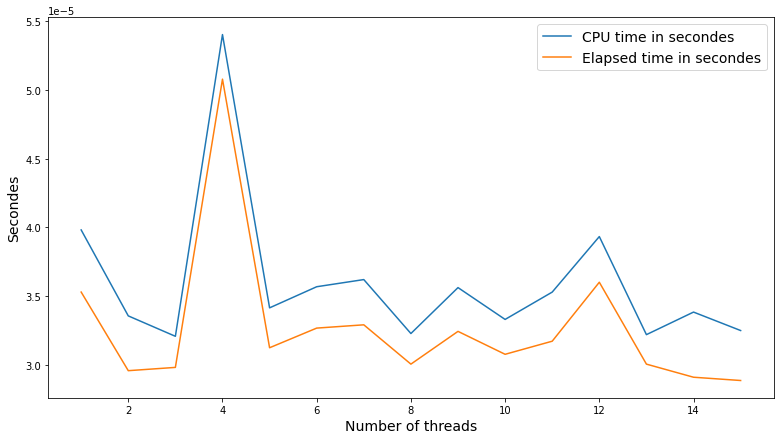

In [16]:
plt.figure(figsize=(13, 7))
threads = np.arange(1, n_threads, 1)
plt.plot(threads, CPU_times, label='CPU time in secondes')
plt.plot(threads, elapsed_times, label='Elapsed time in secondes')
plt.xlabel("Number of threads", fontdict=font_axis)
plt.ylabel("Secondes", fontdict=font_axis)
plt.legend(fontsize=14)
plt.show()

## $\textbf{Exercise 3 Jacobi method}$

Considering the following code for a general linear system solver:

$$ A \times x = b $$

using the Jacobi iterative method.
In this exercice, you must solve the system in parallel
   
**Example Output**
    
```bash
System size    : 20 
 Iterations     : 21 
 Stand          : 2.9100049961372497e-08 
 Elapsed Time   : 7.447303771972656 
 CPU time       : 0.921875 
```

In [17]:
def jacobi(a:'float[:,:]', b:'float[:]', x:'float[:]', n:'int', eps:'float', n_threads:'int'):
    
    import numpy as np
    import math
    x_courant = np.empty(n, dtype=np.double)
    iteration = 0
    
    #$omp parallel num_threads(n_threads)
    while(1):
        iteration += 1
        
        #omp for collapse(2)
        for i in range(n):
            x_courant[i] = 0
            for j in range(i):
                x_courant[i] += a[ j, i ] * x[j]
            
            #omp for
            for j in range(i + 1, n):
                x_courant[i] += a[ j, i ] * x[j]

            x_courant[i] = (b[i] - x_courant[i]) / a[ i, i ]

        # Convergence test
        absmax = 0.
        #omp for
        for i in range(n):
            curr = math.fabs(x[i] - x_courant[i])
            if curr > absmax:
                absmax = curr
        stand = absmax / n
        if stand <= eps or iteration > n:
            break

        # copy x_courant into x
        #omp for
        for i in range(n):
            x [i] = x_courant[i]
    
    #$omp end parallel
    
    return stand, iteration


if __name__ == "__main__":

    import numpy as np
    import time, random, math, sys

    # Matrix default dimension
    n = 20
    diag = 20
    n_threads = 8

    # Initialize of the matrices
    np.random.seed(421)  # for reproductibles results
    a = np.random.uniform(0, 1, size=(n, n))
    b = np.random.uniform(0, 1, size=n)

    # We strengthen the main diagonal of the matrix
    for i in range(n):
        a[ i, i ] += diag

    # Initial solution
    x = np.ones(n, dtype=np.double)

    # start CPU timing
    cpu_0 = time.process_time()

    # start Wall timing
    elapsed_0 = time.time()

    # Pyccelize jacobi function
    from pyccel.epyccel import epyccel
    p_jacobi = epyccel(jacobi, language='c', accelerators=['openmp'])

    eps = sys.float_info.epsilon

    # -------------------- computing ------------------
    stand, iteration = p_jacobi(a, b, x, n, eps, n_threads)
    # ------------------ End computing ----------------

    # CPU time
    cpu_1 = time.process_time()
    cpu = cpu_1 - cpu_0

    # Wall timing
    elapsed_1 = time.time()
    elapsed = elapsed_1 - elapsed_0

    print(
        "System size    :", n,          '\n',
        "Iterations     :", iteration,  '\n',
        "Stand          :", stand,      '\n',
        "Elapsed Time   :", elapsed,    '\n',
        "CPU time       :", cpu,        '\n'
    )

System size    : 20 
 Iterations     : 21 
 Stand          : 0.00023089893788530333 
 Elapsed Time   : 0.3265419006347656 
 CPU time       : 0.04928736899999997 



## $\textbf{Exercise 4 Calculation of π}$

The aim of this exercise is to calculate π by numerical integration knowing that Considering the following code for matrix product: $\int_{0}^{1} \frac{4}{1 + x^2} = {\pi} $

The following program is for calculating the value of
π by the rectangle method (mid-point). Let $f(x) = \frac{4}{1 + x^2} $
2 be the function to integrate, N and $ h = \frac{1}{N} $ (respectively) the number of points, and the discretization width on the integration
interval $[0, 1]$.

Analyse the performance of the codes, then optimise  your code using OpenMP directives.

In [18]:
%%file pi.py
def f(a:'float'):
    return 4.0 / (1. + a * a)

def pi(n:'int', h:'float', n_threads:'int'):
    
    #$omp parallel num_threads(n_threads)
    
    #$omp for
    for k in range(100):
        Pi_calc = 0.
        for i in range(n):
            x = h * (i + 0.5)
            Pi_calc += f(x)

        Pi_calc = h * Pi_calc
    
    #$omp end parallel
    
    return Pi_calc

Overwriting pi.py


In [19]:
import time, math

if __name__ == '__main__':
    #                  __
    #  But : calcul de || par la methode des rectangles (point milieu).
    #
    #                   / 1
    #                  |       4            __
    #                  |   ----------  dx = ||
    #                  |    1 + x**2
    #                 / 0


    n = 300

    # Length of the integration interval
    h = 1.0 / n
    n_threads = 8
    
    from pyccel.epyccel import epyccel
    import pi
    pyc_pi = epyccel(pi, language='c', accelerators=['openmp'])

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------

    Pi_calc = pyc_pi.pi(n, h, n_threads)

    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

    # deviation between the estimated value and the calculated value of Pi
    Pi_estime = math.acos(-1)
    deviat = math.fabs(Pi_estime - Pi_calc)

    # Print result
    print(
      "   Number of intervals        :", n,         "\n",
	  "   | Pi_estime - Pi_calcule | :", deviat,    "\n",
	  "   Temps elapsed              :", t_elapsed, "\n",
	  "   Temps CPU                  :", tcpu,      "\n",
        "Execution of PI in parallel with", n_threads, "threads"

    )

   Number of intervals        : 300 
    | Pi_estime - Pi_calcule | : 0.009975347692542602 
    Temps elapsed              : 0.0003044605255126953 
    Temps CPU                  : 0.000304811000000349 
 Execution of PI in parallel with 8 threads


## $\textbf{Exercise 5 Reduction of an array}$

The given program contained in the `reduction_tab.py` file is extracted from a chemistry code. It reduces a three-dimensional array into a vector. The aim of this exercise is to parallelize this calculation kernel without changing the loop order in the provided code (i.e. k,j,i)

1. Analyse the data-sharing attributes of the variables and adapt the source code so that the K outermost loop is parallelized.
2. Compare the performance obtained by using the thread/core binding default execution on Ada and by using scatter binding. Suggest an explanation for the poor performance of the latter.
3. Optimise the source code for the scatter mode with taking into account the memory affinity. Why does this third series of executions give the best performance 

In [20]:
%%file reduction_tab.py

def threads_num():
    from pyccel.stdlib.internal.openmp import  omp_get_num_threads
    return omp_get_num_threads()

def initialize_table(tab:'float[:,:,:]', nmolec:'int', n:'int', nmol:'int'):
    # Initialisation du tableau
    # First-touch pour garantir un fonctionnement optimal sur les systemes NUMA
    
    #$omp parallel
    #$omp for collapse(3)
    for k in range(nmolec):
        for j in range(n):
            for i in range(nmol):
                tab[ i,j,k ] = i + j + k
                
    #$omp end parallel


def reduction(tab:'float[:,:,:]', tab1:'float[:]', tab2:'float[:]', nmolec:'int', nmol:'int', n:'int'):

    #$omp parallel
    #$omp for
    for k in range(nmolec):
        tab1[:nmol] = 0
        
        #omp for collapse(2) reduction(+:tab1)
        for j in range(n):
            for i in range(nmol):
                tab1[i] = tab1[i] + tab[i,j,k]
        tab2[:nmol] = tab2[:nmol] + 2 * tab1[:nmol]
    
    #$omp end parallel
       

Overwriting reduction_tab.py


In [21]:
from os import error

if __name__ == '__main__':
    from pyccel.stdlib.internal.openmp import omp_set_num_threads

    import numpy as np
    import time

    # default dimension
    nmolec = 100
    nmol   = 100
    n      = 10

    tab     = np.empty((nmol, n, nmolec), dtype=np.double)
    tab1    = np.empty((nmol), dtype=np.double)
    tab2    = np.zeros((nmol), dtype=np.double)

    # pyccelize reduction tab module
    from pyccel.epyccel import epyccel
    import reduction_tab
    
    reduction = epyccel(reduction_tab, language='fortran', accelerators=['openmp'])
    
    print("Execution of reduction table in parallele with", reduction.threads_num(), "threads")

    # initialize tab 
    reduction.initialize_table(tab, nmol, n, nmolec)

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------
    omp_set_num_threads(6)
    reduction.reduction(tab, tab1, tab2, nmolec, nmol, n)
    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

    # verification of results
    tab2c = np.zeros((nmol), dtype=np.double)
    for k in range(nmolec):
        tab1c = np.zeros((nmol), dtype=np.double)
        for j in range(n):
            for i in range(nmol):
                tab1c[i] = tab1c[i] + tab[i, j, k]
        tab2c [:] = tab2c[:nmol] + 2 * tab1c[:]
    err = np.max(np.abs(tab2c - tab2) / np.abs(tab2c))
    print(
        "Temps elapsed  :", t_elapsed   , "\n",
        "Temps CPU      :", tcpu        , "\n",
        "Erreur relative:", err         , "\n"
    )

Execution of reduction table in parallele with 1 threads
Temps elapsed  : 0.0072901248931884766 
 Temps CPU      : 0.040490580000000165 
 Erreur relative: 0.41267045454545453 



# $\textbf{Exercise 6 Matrix product by the Strassen algorithm}$

Considering the following code that calculates the matrix product :

$$C = A \times B$$

by using Strassen’s recursive algorithm.

In this exercise, you must :
1. Analyse and parallelize the code by using OpenMP tasks.
2. Measure the code performance and plot the speedup curves obtained.

In [22]:
import time, math
import numpy as np

def threads_num():
    from pyccel.stdlib.internal.openmp import  omp_get_num_threads
    return omp_get_num_threads()

def strassen_multiply(A:'float[:,:]', B:'float[:,:]', C:'float[:,:]', n:'int'):
    import numpy as np
    
    if n & 1 != 0  or n < 128:
        C[:] = np.matmul(A, B)
    else:
        n2 = n // 2
        A11 = A[ 0:n2, 0:n2 ]
        A21 = A[ n2:n, 0:n2 ]
        A12 = A[ 0:n2, n2:n ]
        A22 = A[ n2:n, n2:n ]
        B11 = B[ 0:n2, 0:n2 ]
        B21 = B[ n2:n, 0:n2 ]
        B12 = B[ 0:n2, n2:n ]
        B22 = B[ n2:n, n2:n ]

        Q1 = np.empty((n2, n2), dtype=np.double)
        Q2 = np.empty((n2, n2), dtype=np.double)
        Q3 = np.empty((n2, n2), dtype=np.double)
        Q4 = np.empty((n2, n2), dtype=np.double)
        Q5 = np.empty((n2, n2), dtype=np.double)
        Q6 = np.empty((n2, n2), dtype=np.double)
        Q7 = np.empty((n2, n2), dtype=np.double)
        
        strassen_multiply(A11+A22, B11+B22, Q1, n2)
        strassen_multiply(A21+A22, B11, Q2, n2)
        strassen_multiply(A11, B12-B22, Q3, n2)
        strassen_multiply(A22, -B11+B21, Q4, n2) 
        strassen_multiply(A11+A12, B22, Q5, n2)
        strassen_multiply(-A11+A21, B11+B12, Q6, n2)
        strassen_multiply(A12-A22, B21+B22, Q7, n2)
        C[   :n2,   :n2 ] = Q1+Q4-Q5+Q7
        C[ n2: n,   :n2 ] = Q2+Q4
        C[   :n2, n2:n  ] = Q3+Q5
        C[ n2:n , n2:n  ] = Q1+Q3-Q2+Q6
        
def calcul_erreur(n, A, B, C):
    D = np.matmul(A, B) 
    error = 0.0
    for i in range(n):
        for j in range(n):
            e = C[ i, j ] - D[ i, j ]
            error += e * e

    error = math.sqrt(error) / n
    return error

In [23]:
if __name__ == '__main__':
    n = 256

    # Initialize Matrices
    np.random.seed(421)
    A = np.random.uniform(0, 1, (n, n))
    B = np.random.uniform(0, 1, (n, n))
    C = np.empty((n,n), dtype=np.double)

    from pyccel.epyccel import epyccel
    strassen = epyccel(strassen_multiply, accelerators=['openmp'])
    num_threads = epyccel(threads_num, accelerators=['openmp'])
    print("Execution of Strassen in parallele with", num_threads(), "threads")
    
    
    # Start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time
    # -------------------- computing ------------------
    # Calcul C=A*B par la methode recursive de Strassen
    strassen(A, B, C, n)
    # ------------------ end computing ----------------
    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0
    # Print result
    print(
      "   Erreur        :", calcul_erreur(n, A, B, C),  "\n",
	  "   Temps elapsed :", t_elapsed,                  "\n",
	  "   Temps CPU     :", tcpu,                       "\n",
    )


Execution of Strassen in parallele with 1 threads
   Erreur        : 3.377379142794413e-14 
    Temps elapsed : 0.003322124481201172 
    Temps CPU     : 0.0033694850000003385 

